## Логистическая регрессия

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification

%matplotlib inline

plt.style.use("ggplot")

Реализуйте обучение логистической регрессии с $L^1$ и $L^2$ регуляризацией с помощью метода Stochastic Gradient Descent (SGD)

#### Замечания
* В SGD градиент расчитывается по одному случайному объекту
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в выборке (тем или иным способом)

# Реализация модели

In [2]:
from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    min_value = 1e-15
    max_value = 1 - min_value


    def __init__(self, C=1, alpha=0.01, max_epoch=10, penalty="l2"):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.penalty = penalty
        self.theta = None
        self.history = []
        self.fitted = False

    def fit(self, X, y=None, partial=False):
        '''
        Обучение модели
        '''           
        def apply_penalty(gradients):
            temp_theta = np.copy(self.theta)
            temp_theta[0,] = np.zeros(self.theta.shape[1])
            if self.penalty == "l1":
                gradients += self.C * np.abs(temp_theta)
            elif self.penalty == "l2":
                gradients += self.C * temp_theta #  should be squared, but I've no idea how to avoid overflows 

        def get_error(X, y):
            predictions = self.sigmoid(X.dot(self.theta))
            error = -np.sum(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))

            temp_theta = np.copy(self.theta)
            temp_theta[0,] = np.zeros(self.theta.shape[1])
            if self.penalty == "l1":
                error += self.C * np.sum(np.abs(temp_theta))
            elif self.penalty == "l2":
                error += self.C * np.sum(temp_theta.T.dot(temp_theta))
            return error / X.shape[0]

        X_b = np.c_[np.ones((X.shape[0], 1)), X].astype(np.float64)
        y_b = y.reshape(y.shape[0], 1).astype(np.float64)

        if self.theta is None:
            self.theta = np.random.uniform(size=(X_b.shape[1], 1)).astype(np.float64)
        elif not partial:
            raise Exception("Already fitted, use 'partial_fit' instead")

        for epoch in range(self.max_epoch):
            m = X_b.shape[0]
            p = np.random.permutation(m)

            for index in p:
                xi = X_b[[index],...]
                yi = y_b[[index],...]

                gradients = xi.T.dot(self.sigmoid(np.dot(xi, self.theta)) - yi)
                apply_penalty(gradients)
                self.theta -= self.alpha * gradients

            error = get_error(X_b, y_b)
            self.history.append(error)

        self.fitted = True
        
        return self
    
    def partial_fit(self, X, y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''
        self.fit(X, y)
        return self
    
    def predict(self, X):
        '''
        Возвращение метки класса
        '''
        return (self.predict_proba(X) >= .5).astype(int)

    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''
        X_b = np.c_[np.ones((len(X), 1)), X]
        return self.sigmoid(X_b.dot(self.theta))

    def sigmoid(self, x):
        return np.clip(1. / (1. + np.exp(-x)), self.min_value, self.max_value)

## Проверка на синтетических данных

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

In [3]:
def plot_decision_boundary(X, y, clfs_with_titles):
    xx, yy = np.mgrid[-5:5:.01, -5:5:.01]
    grid = np.c_[xx.ravel(), yy.ravel()]
        
    f, ax = plt.subplots(ncols=len(clfs_with_titles), figsize=(18, 5))
    
    contours = []
    for i in range(len(clfs_with_titles)):
        title, clf = clfs_with_titles[i]
        probs = clf.predict_proba(grid)[:, 0].reshape(xx.shape)
        contour = ax[i].contourf(xx, yy, probs, 25, cmap="RdBu", vmin=0, vmax=1)
        contours.append(contour)
        ax[i].scatter(X[100:,0], X[100:, 1], c=y[100:], s=50, cmap="RdBu", vmin=-.2, vmax=1.2, edgecolor="white", linewidth=1)
        ax[i].set(aspect="equal", xlim=(-5, 5), ylim=(-5, 5), xlabel="$X_1$", ylabel="$X_2$", 
                   title="C={}, a={}, max epoch={}, penalty={}".format(*title))
    
    ax_c = f.colorbar(contours[-1], fraction=0.04, pad=0.05)
    ax_c.set_label("$P(y == 1)$")
    ax_c.set_ticks([0, .25, .5, .75, 1])    

In [4]:
X, y = make_classification(400, 2, 2, 0, weights=[.5, .5], random_state=0)

In [5]:
# every combination of viable parameters values (c=1 and a=1 cause overflows)
grid = [((c, a, e, p), MySGDClassifier(c, a, e, p).fit(X, y)) for c in [.0001, .001, .01, .1] 
                                                              for a in [.0001, .001, .01, .1]
                                                              for e in [10, 100, 1000]
                                                              for p in [None, "l1", "l2"]]

### Let's check how regularization affects classification results

#### After 10 epochs

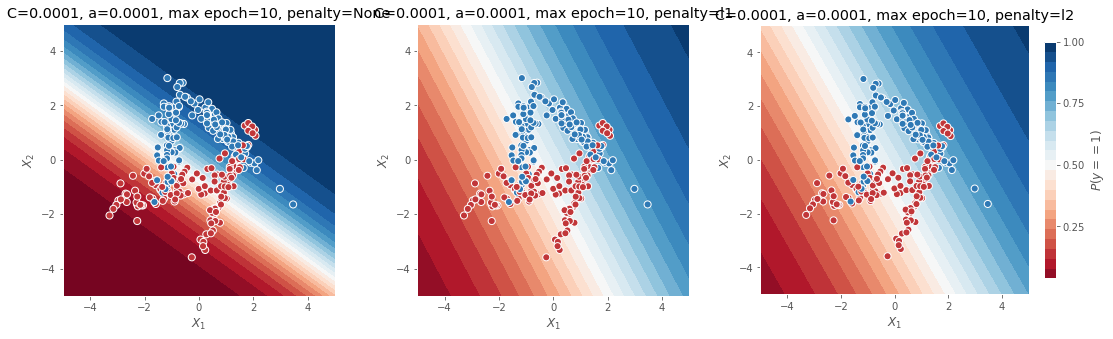

In [6]:
plot_decision_boundary(X, y, grid[0:3])

#### After 100 epochs

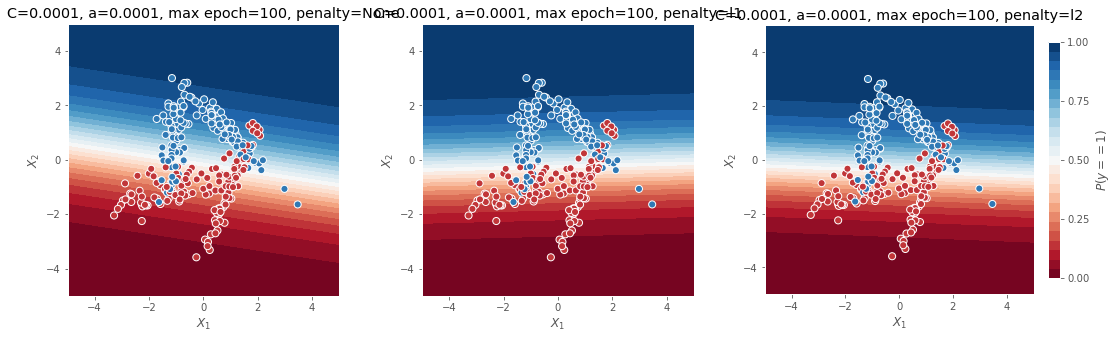

In [7]:
plot_decision_boundary(X, y, grid[3:6])

#### After 1000 epochs

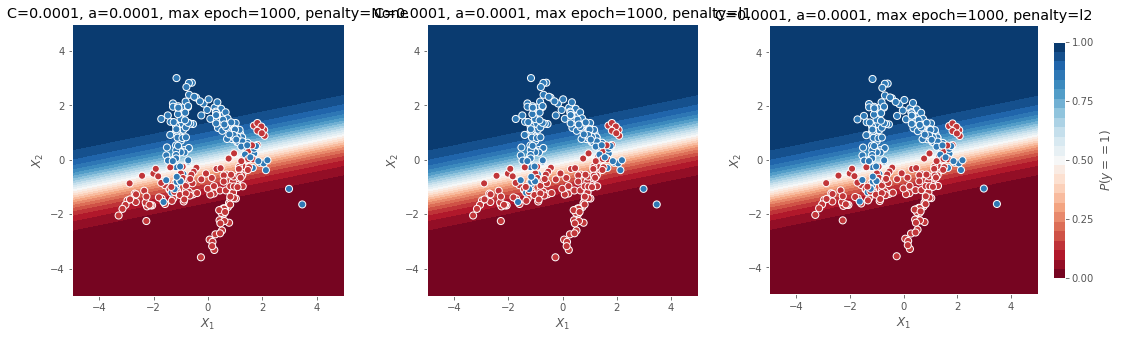

In [8]:
plot_decision_boundary(X, y, grid[6:9])

#### Conclusion  
Regularization's effect on classification results diminishes as epoch count grows. Also classifier's confidence grows with epoch count (or maybe it just overfits).

## Анализ сходимости

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/эпохи (выбрать одно) для разных `alpha`.

In [9]:
def plot_error(clfs_with_titles):
    f, ax = plt.subplots(ncols=len(clfs_with_titles), figsize=(20, 5))
    
    for i in range(len(clfs_with_titles)):
        title, clf = clfs_with_titles[i]
        ax[i].plot(range(1, len(clf.history) + 1), clf.history, marker='.')
        ax[i].set(xlabel="Epochs", ylabel="Error", title="C={}, a={}, max epoch={}, penalty={}".format(*title))

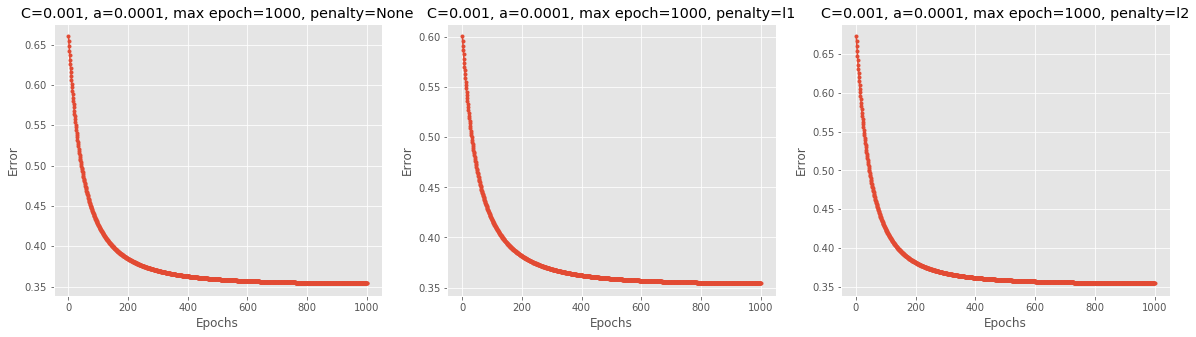

In [10]:
plot_error(grid[42:45])

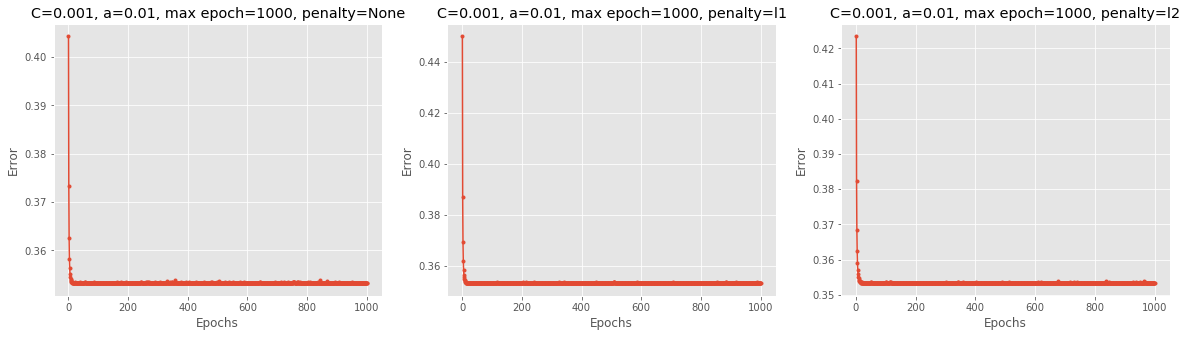

In [11]:
plot_error(grid[60:63])

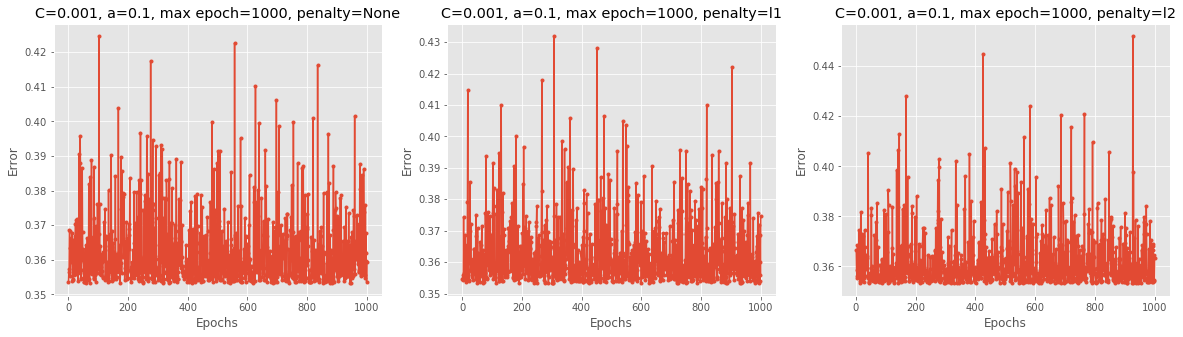

In [12]:
plot_error(grid[69:72])

#### Conclusion  
As we can see, `alpha`'s effect on model's error and conveergence rate is very significant.  
With `alpha=0.001` model converges after ~800 epochs, with `alpha=0.01` convergence rate accelerates and error is minimized almost instantly, but with `alpha=0.1` model never converges.